## Getting Started

In [1]:
# Setup the environment depending on weather we are running in Google Colab or Jupyter Notebook
from IPython import get_ipython

colab = False
if "google.colab" in str(get_ipython()):
    print("Running on CoLab")
    from PIL import Image
    colab = True

    # Downloading only the "output" directory from the repository
    !git init .
    !git remote add -f origin https://github.com/Play-Your-Part/tutorials.git
    !git config core.sparseCheckout true
    !echo "output" >> .git/info/sparse-checkout
    !git pull origin main

    # Installing Ollama
    !curl -fsSL https://ollama.com/install.sh | sh
    %pip install simpleneighbors

    # Installing sdialog
    !git clone https://github.com/idiap/sdialog.git
    %cd sdialog
    %pip install -e .
    %cd ..
else:
    print("Running in Jupyter Notebook")
    # Little hack to avoid the "OSError: Background processes not supported." error in Jupyter notebooks"
    import os
    get_ipython().system = os.system

Running in Jupyter Notebook


In [2]:
# Let's clone the STAR dataset repository
!git clone https://github.com/RasaHQ/STAR.git datasets/STAR

# Let's check that `dialogues` and `tasks` folders are inside `datasets/STAR`
!ls datasets/STAR

LICENSE.txt
README.md
apis
dialogues
tasks


fatal: destination path 'datasets/STAR' already exists and is not an empty directory.


0

In [3]:
from sdialog.datasets import STAR

STAR_PATH = "datasets/STAR/"
STAR.set_path(STAR_PATH)

!OLLAMA_KEEP_ALIVE=-1 ollama serve > /dev/null 2>&1 &
!sleep 10

[2025-07-22 11:31:31] INFO:datasets:PyTorch version 2.7.0 available.


0

## Evaluation

In [4]:
original_dialogs = STAR.get_dialogs(task_name="doctor_followup", happy=True, multitask=False)
print('Total number of happy "doctor_followup" dialogues:', len(original_dialogs))

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Total number of happy "doctor_followup" dialogues: 105


In [5]:
from sdialog import Dialog

single_llm_dialogs = Dialog.from_file("output/STAR/full-generation/txt")
multi_agent_dialogs = Dialog.from_file("output/STAR/multi-agents/txt")
orche_dialogs = Dialog.from_file("output/STAR/multi-agents+orchestration/txt")

In [6]:
len(single_llm_dialogs)

105

In [7]:
single_llm_dialogs[0].print()

[dialog_id] 1
--- Dialogue Begins ---
[System] Hello, how can I help?
[User] Hi, could you please remind me of my doctor's instructions for the medicine?
[System] Could I get your name, please?
[User] My name is Alexis.
[System] Who is your doctor?
[User] I was seeing Dr. Morgan.
[System] Your instructions are: Take the medicine three times a day, 30 minutes before meals.
[User] Thank you, that's helpful.
[System] Is there anything else that I can do for you?
[User] No, that's all. Thank you.
[System] Thank you and goodbye.
--- Dialogue Ends ---


In [8]:
from sdialog.evaluation import LLMJudgeRealDialog

judge_real = LLMJudgeRealDialog()

judge_real(single_llm_dialogs[0])

[2025-07-22 11:31:47] INFO:sdialog.util:Loading ChatOllama model: gemma3:27b


0

In [9]:
judge_real.judge(single_llm_dialogs[0])

LLMJudgeYesNoOutput(yes=False, feedback=None)

In [10]:
judge_real.judge(single_llm_dialogs[0], feedback=True)

LLMJudgeYesNoOutput(yes=False, feedback="The dialogue is very short and lacks depth. While coherent, it's a highly functional, transactional exchange lacking any of the subtleties or natural conversational markers (hesitations, informal language, etc.) that would suggest a human interaction. It reads like a very basic chatbot fulfilling a simple request. The responses are direct and lack any personality or genuine intent.")

In [11]:
orche_dialogs[0].print()

[dialog_id] 1
--- Dialogue Begins ---
[System] Hello, how can I help?
[User] Hi! Can you tell me again how often I should be taking my medication that Dr. Morgan prescribed? I seem to have forgotten and I want to make sure I’m doing it correctly.
[System] Could I get your name, please? And don't worry, I can help clarify the instructions for your medication.
[User] Of course, my name is Alexis. Thanks a lot for your help! Dr. Johnson was the one who gave me this prescription during my last visit, but I’m having trouble remembering the dosage details. Could you assist with that?
[System] Thank you for letting me know, Alexis. Who is your doctor? I see here it's Dr. Johnson providing your care. Let me confirm the instructions with him.
[User] Yes, my apologies! It was Dr. Johnson who prescribed the medication during my recent visit. While we're on the topic, do you happen to have any updates about my condition since then? I've been feeling a bit off lately and wasn't sure if it's related

In [12]:
judge_real(orche_dialogs[0])

1

In [13]:
judge_real.judge(orche_dialogs[0], feedback=True)

LLMJudgeYesNoOutput(yes=True, feedback="The dialogue exhibits characteristics of a real human conversation. It demonstrates sufficient length and depth, with a natural flow of questions and responses. The user provides clarifying information and asks follow-up questions, while the system provides helpful and contextually appropriate answers. The presence of acknowledgements ('Thanks a lot', 'Thanks so much'), apologies ('my apologies'), and polite closings contributes to a natural conversational style. The slight correction regarding the doctor's name further supports its realism.")

In [14]:
judge_real.judge(orche_dialogs[:3], feedback=True)

LLMJudgeYesNoOutput(yes=[True, True, True], feedback=["This dialogue feels very natural, with the user expressing slight forgetfulness and gratitude. The system's responses are appropriate and the flow is conversational. It exhibits characteristics of a real human-human interaction.", 'This dialogue is also very realistic. The back-and-forth questioning and confirmation of details mirrors a typical patient-assistant conversation. The repetition to confirm understanding is natural.', "This dialogue is similar to the others in its realism. The user's request and the system's response are perfectly logical and consistent with a real conversation. The conversational flow and language used indicate a human-like interaction."])

In [15]:
from sdialog.evaluation import FrequencyEvaluator

freq_real = FrequencyEvaluator(judge_real)

freq_real(single_llm_dialogs[:10])

Computing frequency-llm-judge-real-dialog scores for candidate dataset:   0%|          | 0/10 [00:00<?, ?it/s]

0.0

In [16]:
freq_real(orche_dialogs[:10])

Computing frequency-llm-judge-real-dialog scores for candidate dataset:   0%|          | 0/10 [00:00<?, ?it/s]

0.3

In [17]:
target_dialogs = {
    "full-generation": single_llm_dialogs,
    "multi-agents": multi_agent_dialogs,
    "multi-agents+orchestration": orche_dialogs,
}

target_dialogs_outlier = Dialog.from_file("datasets/Primock-57/json/")
target_dialogs_outlier[:] = [d.rename_speaker("doctor", "system").rename_speaker("patient", "user")
                              for d in target_dialogs_outlier]
target_dialogs["outlier"] = target_dialogs_outlier

In [18]:
from sdialog.evaluation import BaseDialogScore

class DialogLength(BaseDialogScore):
    def score(self, dialog: Dialog) -> int:
        return len(dialog)

In [ ]:
from sdialog.evaluation import DatasetComparator
from sdialog.evaluation import DialogFlowPPL, LLMJudgeRealDialog
from sdialog.evaluation import KDEDivergenceEvaluator, StatsEvaluator, FrequencyEvaluator

real_dialog_judge = LLMJudgeRealDialog(feedback=True)
fppls = DialogFlowPPL(single_llm_dialogs)
fppl = DialogFlowPPL(original_dialogs, use_softmax=False)
dialog_length = DialogLength(name="turn length")

comparator = DatasetComparator(
    evaluators=[
        KDEDivergenceEvaluator(fppl),
        KDEDivergenceEvaluator(fppls),
        FrequencyEvaluator(real_dialog_judge),
        StatsEvaluator(dialog_length)
    ]
)

comparator(target_dialogs)

[2025-07-22 11:39:39] INFO:sdialog.util:Loading ChatOllama model: gemma3:27b


[2025-07-22 11:39:39] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-07-22 11:39:42] INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
[2025-07-22 11:39:42] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base
[2025-07-22 11:39:43] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-07-22 11:39:46] INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
[2025-07-22 11:39:46] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Computing reference kde-divergence-fppl scores:   0%|          | 0/105 [00:00<?, ?it/s]

Computing reference kde-divergence-fppl+sm scores:   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-divergence-fppl scores for dataset 'full-generation':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-divergence-fppl+sm scores for dataset 'full-generation':   0%|          | 0/105 [00:00<?, ?it/s]

Computing stats-turn length scores for dataset 'full-generation':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-divergence-fppl scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-divergence-fppl+sm scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing stats-turn length scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-divergence-fppl scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:00<?…

Computing kde-divergence-fppl+sm scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:0…

Computing stats-turn length scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:00<?, …

Computing kde-divergence-fppl scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing kde-divergence-fppl+sm scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing stats-turn length scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

╒════════════════════════════╤══════════════════════════╤══════════════════════════╤═════════════════════════════╤═════════════════════════════╤══════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤════════════════════════════╕
│ dataset                    │   kde-divergence-fppl-cs │   kde-divergence-fppl-kl │   kde-divergence-fppl+sm-cs │   kde-divergence-fppl+sm-kl │   stats-turn length-mean │   stats-turn length-std │   stats-turn length-min │   stats-turn length-max │   stats-turn length-median │
╞════════════════════════════╪══════════════════════════╪══════════════════════════╪═════════════════════════════╪═════════════════════════════╪══════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪════════════════════════════╡
│ full-generation            │                     0.17 │                     1.68 │                       -0.00 │                        0.00 │                   

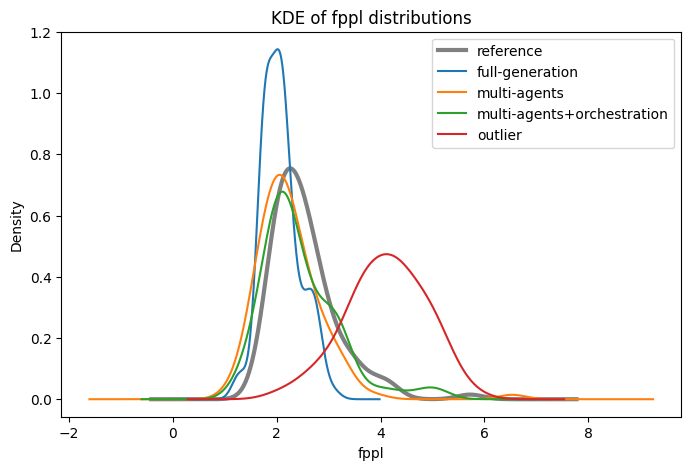

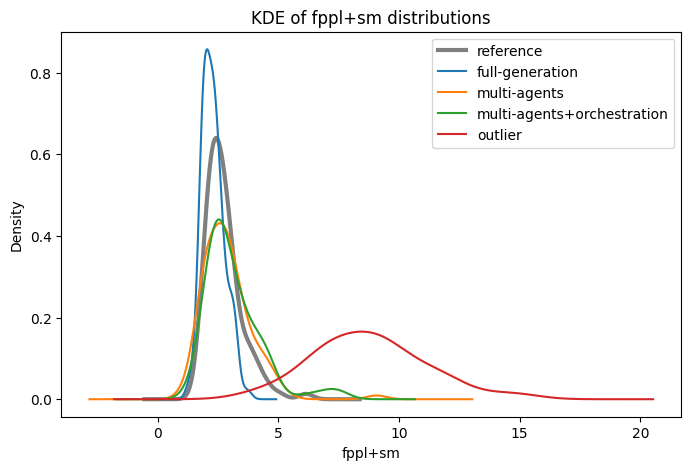

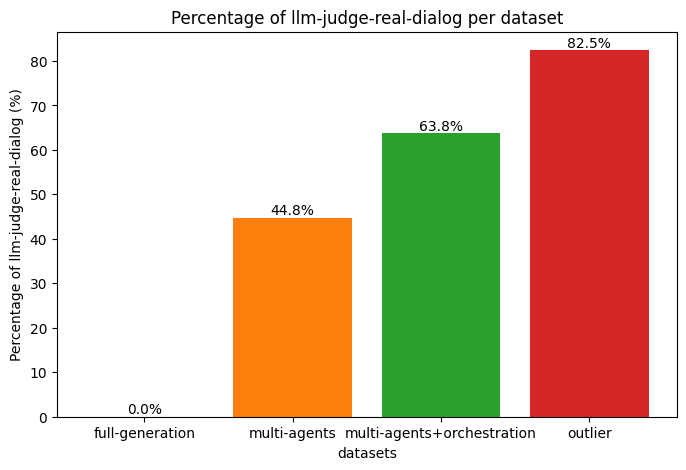

In [ ]:
comparator.plot()